In [1]:
import sys,time
sys.path.append('../')
from smodels.theory.tree import Tree, InclusiveParticleNode
from smodels.theory.auxiliaryFunctions import bracketToProcessStr,flattenArray
from smodels.experiment.defaultFinalStates import finalStates
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model
from smodels.theory.tree import Tree
from smodels.theory.treeMatcher import TreeMatcher
from smodels.tools.physicsUnits import fb, GeV, TeV, pb
from smodels.theory.element import Element
from smodels.experiment.txnameObj import TxName, TxNameData
from smodels.experiment.infoObj import Info
from smodels.theory.auxiliaryFunctions import (elementsInStr, removeUnits, unscaleWidth,
                                               rescaleWidth, flattenArray, reshapeList,
                                               removeInclusives, addInclusives)

import networkx as nx
import numpy as np
import unum

In [2]:
filePath = '../test/database/13TeV/ATLAS/ATLAS-SUSY-2016-08/data/T5Disp.txt'
globalInfo = Info('../test/database/13TeV/ATLAS/ATLAS-SUSY-2016-08/globalInfo.txt')
infoObj = Info('../test/database/13TeV/ATLAS/ATLAS-SUSY-2016-08/data/dataInfo.txt')
databaseParticles = finalStates
tx = TxName(filePath,globalInfo,infoObj,databaseParticles)

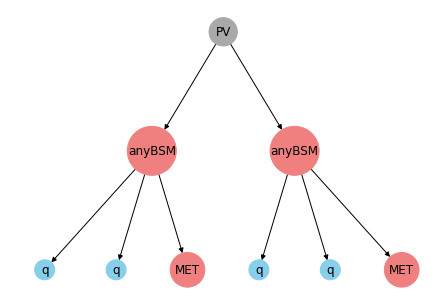

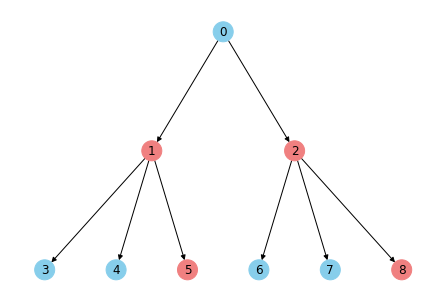

[(PV, 0), (anyBSM, 1), (anyBSM, 2), (q, 3), (q, 4), (MET, 5), (q, 6), (q, 7), (MET, 8)]


In [3]:
el = list(tx.elementMap.keys())[0]
el.drawTree()
el.drawTree(labelAttr='node')
print([(n,n.node) for n in el.tree.nodes])

In [4]:
for k in sorted(tx.dataMap.keys()):
    print(k,tx.dataMap[k])

0 (1, 'mass', 1.00E+00 [GeV])
1 (5, 'mass', 1.00E+00 [GeV])
2 (2, 'mass', 1.00E+00 [GeV])
3 (8, 'mass', 1.00E+00 [GeV])
4 (1, 'totalwidth', 1.00E+00 [GeV])
5 (2, 'totalwidth', 1.00E+00 [GeV])


In [5]:
for k in sorted(tx.arrayMap.keys()):
    print(k,tx.arrayMap[k])

0 ((0, 0, 0), 'mass', 1.00E+00 [GeV], 1)
1 ((0, 1, 0), 'mass', 1.00E+00 [GeV], 5)
2 ((1, 0, 0), 'mass', 1.00E+00 [GeV], 2)
3 ((1, 1, 0), 'mass', 1.00E+00 [GeV], 8)
4 ((0, 0, 1), 'totalwidth', 1.00E+00 [GeV], 1)
5 ((1, 0, 1), 'totalwidth', 1.00E+00 [GeV], 2)


In [6]:
print(tx.y_unit)

1.00E+00 [fb]


In [7]:
massPoint = [[(100*GeV,1e-3*GeV),50*GeV],[(0.2*TeV,1e6*GeV),10*GeV]]
print([np.round(x,4) for x in tx.transformPoint(massPoint)])

[100.0, 50.0, 200.0, 10.0, 62.1698, 82.8931]


In [8]:
data = [ [[[(100*GeV,1e-3*GeV),50*GeV],[(200*GeV,1e6*GeV),10*GeV]],0.1*fb],  
        [[[(400*GeV,1*GeV),150*GeV],[(300*GeV,10*GeV),30*GeV]],10.*pb]]
xvalues,yvalues = tx.transformData(data)
for ix,x in enumerate(xvalues):
    print([np.round(xx,4) for xx in x],np.round(yvalues[ix],4))

[100.0, 50.0, 200.0, 10.0, 62.1698, 82.8931] 0.1
[400.0, 150.0, 300.0, 30.0, 69.0776, 71.3801] 10000.0


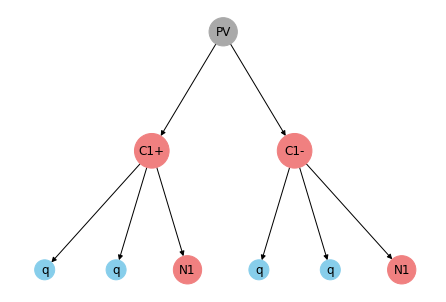

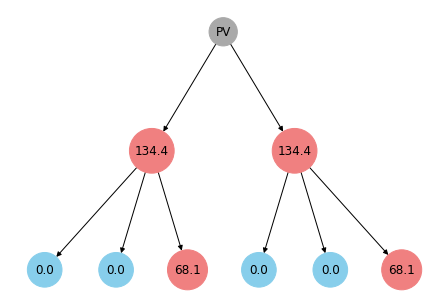

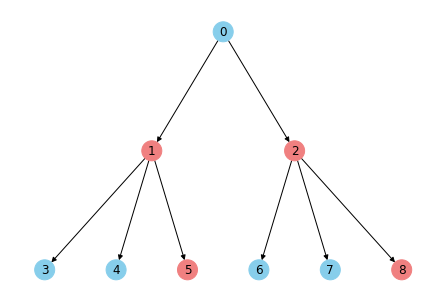

In [9]:
slhafile="../inputFiles/slha/lightEWinos.slha"
model = Model(BSMList,SMList)
model.updateParticles(inputFile=slhafile,promptWidth = 1e-12*GeV)
elB = Element("[[['u','u~']],[['d','d~']]]",model=model,
             intermediateState=[['C1+'],['C1-']],finalState=['N1','N1'])

elMatch = el.matchElementTo(elB)
elMatch.drawTree()
elMatch.drawTree(labelAttr='mass',attrUnit=GeV)
elMatch.drawTree(labelAttr='node')

In [10]:
elementData = [np.round(x,3) for x in tx.getDataFromElement(elMatch)]
print(elementData)
v = tx.txnameData.getValueFor(elementData)
print(v)
reweigtF = tx.getReweightingFor(elMatch)
print(reweigtF)

[134.4, 68.1, 134.4, 68.1, 184.207, 184.207]
None
1.0


In [11]:
elementData = [1450.,100.,1450.,100.,rescaleWidth(5e-17),rescaleWidth(5e-17)]
v = tx.txnameData.getValueFor(elementData)
print(np.round(v,4),'(expected  ~ 1.5)')

1.5474 (expected  ~ 1.5)


In [12]:
# Change chargino width to get a result:
C1p = model.getParticlesWith(label='C1+')[0]
C1m = model.getParticlesWith(label='C1-')[0]
N1 = model.getParticlesWith(label='N1')[0]
C1p.totalwidth = 5e-17*GeV
C1m.totalwidth = 5e-17*GeV
C1p.mass = 1450.*GeV
C1m.mass = 1450.*GeV
N1.mass = 100.*GeV
v = tx.getULFor(elMatch)
print(v)

1.55E+00 [fb]


In [13]:
p = tx.txnameData.PCAtransf(elementData)
# print(p)
pInv = tx.txnameData.inversePCAtransf(p)
pInv = [tx.txnameData.round_to_n(x,5) for x in pInv[:]]
print(pInv)
print(pInv == [tx.txnameData.round_to_n(x,5) for x in elementData])

[1450.0, 100.0, 1450.0, 100.0, 31.543, 31.543]
True


In [14]:
print(tx.inverseTransformPoint(elementData))

[[(1.45E+03 [GeV], 5.00E-17 [GeV2]), 1.00E+02 [GeV]], [(1.45E+03 [GeV], 5.00E-17 [GeV2]), 1.00E+02 [GeV]]]
